# 1. Sales and Profit Forecasting

Best parameters for sales model: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 20}
Sales - Cross-Validation MAE scores: [ -9.48731577  -9.7387507  -10.19824549 -11.80643199  -7.84583683]
Sales - Mean MAE: 9.815316155736427
Best parameters for profit model: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': None}
Profit - Cross-Validation MAE scores: [-10.78573869 -10.86438393  -8.71043522 -11.67609147 -11.52955781]
Profit - Mean MAE: 10.713241423022327
Sales - R2 Score: 0.992756004338757
Sales - MAPE: 0.00250948373138197
Profit - R2 Score: 0.9171765544355361
Profit - MAPE: 24443351225877.895
Number of sales outliers: 1065
Number of profit outliers: 936
Sales Outliers:
      Row ID        Order ID Order Date  Ship Date       Ship Mode  \
1          2  CA-2016-152156 2016-11-08 2016-11-11    Second Class   
3          4  US-2015-108966

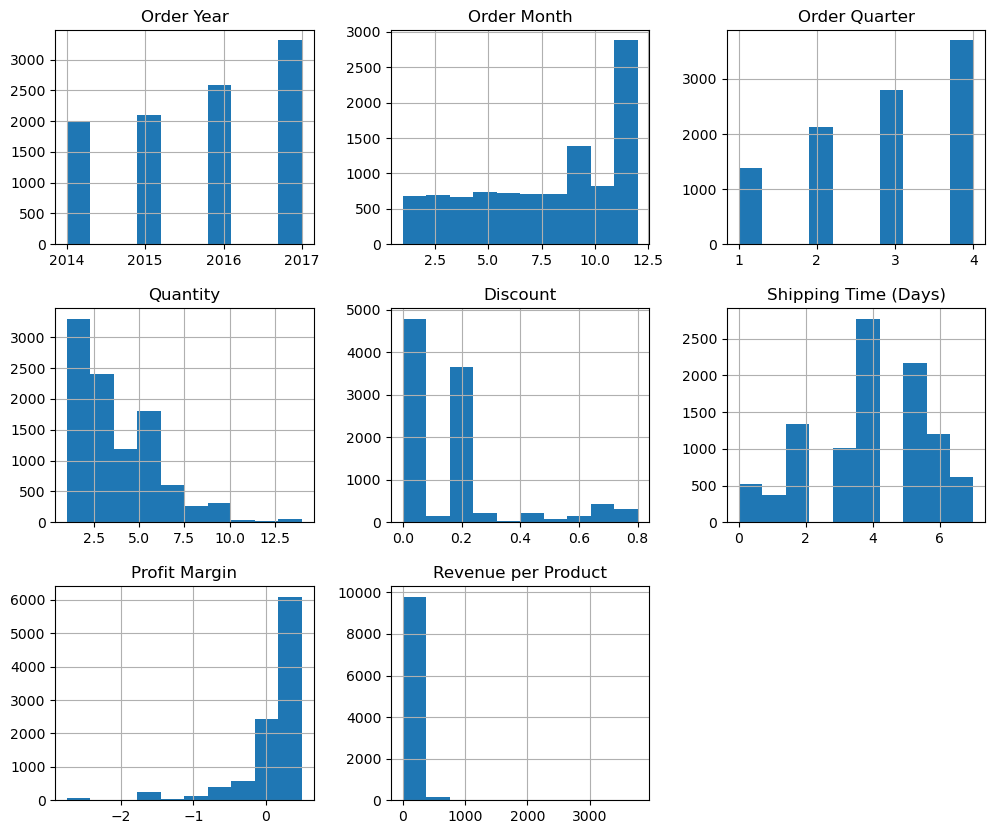

In [3]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE  # Adding SMOTE library to handle imbalanced data
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

# Reading data from the CSV file
df = pd.read_csv('Sample - Superstore.csv', encoding='ISO-8859-1')

# Converting the 'Order Date' and 'Ship Date' columns to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Creating time-based calculations, such as the month and year of the order
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Quarter'] = df['Order Date'].dt.quarter

# Calculating Net Sales (Revenue after discounts)
df['Net Sales'] = df['Sales'] * (1 - df['Discount'])

# Calculating shipping time
df['Shipping Time (Days)'] = (df['Ship Date'] - df['Order Date']).dt.days

# Adding new features: "Profit Margin" and "Revenue per Product"
df['Profit Margin'] = df['Profit'] / df['Sales']
df['Revenue per Product'] = df['Sales'] / df['Quantity']

# Handling imbalanced data (if applicable):
# Using SMOTE to increase the number of samples in imbalanced classes (based on Profit or Revenue)
# Only apply SMOTE if class distribution is imbalanced (e.g., low profit, low revenue)

# Selecting features
features = ['Order Year', 'Order Month', 'Order Quarter', 'Category', 'Sub-Category', 'Quantity', 'Discount', 'Shipping Time (Days)', 'Profit Margin', 'Revenue per Product']

# Target columns are sales and profit
target_sales = 'Sales'
target_profit = 'Profit'

# Creating data for the model
X = df[features]
y_sales = df[target_sales]
y_profit = df[target_profit]

# Building a pipeline for the sales prediction model
numeric_features = ['Order Year', 'Order Month', 'Order Quarter', 'Quantity', 'Discount', 'Shipping Time (Days)', 'Profit Margin', 'Revenue per Product']
categorical_features = ['Category', 'Sub-Category']

# Data preprocessing: Encoding, scaling, and handling missing values
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handling missing values
    ('scaler', StandardScaler())  # Scaling data
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handling missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding
])

# Combining preprocessing steps for both numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Creating a complete pipeline for RandomForest with preprocessing
sales_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

profit_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# **Hyperparameter Tuning with RandomizedSearchCV** (Optimizing parameters for RandomForest)
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Using RandomizedSearchCV to optimize parameters for the sales prediction model
sales_random_search = RandomizedSearchCV(sales_pipeline, param_distributions=param_grid, n_iter=10, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42)
sales_random_search.fit(X, y_sales)

print(f"Best parameters for sales model: {sales_random_search.best_params_}")

# Evaluating the sales prediction model with Cross-validation
sales_cv_scores = cross_val_score(sales_random_search.best_estimator_, X, y_sales, cv=5, scoring='neg_mean_absolute_error')
print(f"Sales - Cross-Validation MAE scores: {sales_cv_scores}")
print(f"Sales - Mean MAE: {-sales_cv_scores.mean()}")

# Evaluating the profit prediction model with Cross-validation
profit_random_search = RandomizedSearchCV(profit_pipeline, param_distributions=param_grid, n_iter=10, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42)
profit_random_search.fit(X, y_profit)

print(f"Best parameters for profit model: {profit_random_search.best_params_}")

profit_cv_scores = cross_val_score(profit_random_search.best_estimator_, X, y_profit, cv=5, scoring='neg_mean_absolute_error')
print(f"Profit - Cross-Validation MAE scores: {profit_cv_scores}")
print(f"Profit - Mean MAE: {-profit_cv_scores.mean()}")

# **Additional metrics for model evaluation**
y_pred_sales = sales_random_search.best_estimator_.predict(X)
y_pred_profit = profit_random_search.best_estimator_.predict(X)

# Calculating additional metrics
print(f"Sales - R2 Score: {r2_score(y_sales, y_pred_sales)}")
print(f"Sales - MAPE: {mean_absolute_percentage_error(y_sales, y_pred_sales)}")

print(f"Profit - R2 Score: {r2_score(y_profit, y_pred_profit)}")
print(f"Profit - MAPE: {mean_absolute_percentage_error(y_profit, y_pred_profit)}")

# **Error Analysis**: Analyzing prediction errors
sales_errors = y_sales - y_pred_sales
profit_errors = y_profit - y_pred_profit

# Checking for large errors (outliers)
sales_outliers = np.abs(sales_errors) > sales_errors.quantile(0.95)
profit_outliers = np.abs(profit_errors) > profit_errors.quantile(0.95)

print(f"Number of sales outliers: {sales_outliers.sum()}")
print(f"Number of profit outliers: {profit_outliers.sum()}")

# Displaying samples with large errors (outliers)
print("Sales Outliers:")
print(df[sales_outliers])

print("Profit Outliers:")
print(df[profit_outliers])

# **Saving the trained model**
joblib.dump(sales_random_search.best_estimator_, 'sales_model.pkl')
joblib.dump(profit_random_search.best_estimator_, 'profit_model.pkl')

# Checking the distribution of input features
X[numeric_features].hist(figsize=(12, 10))
plt.show()

# 2. Customer Segmentation

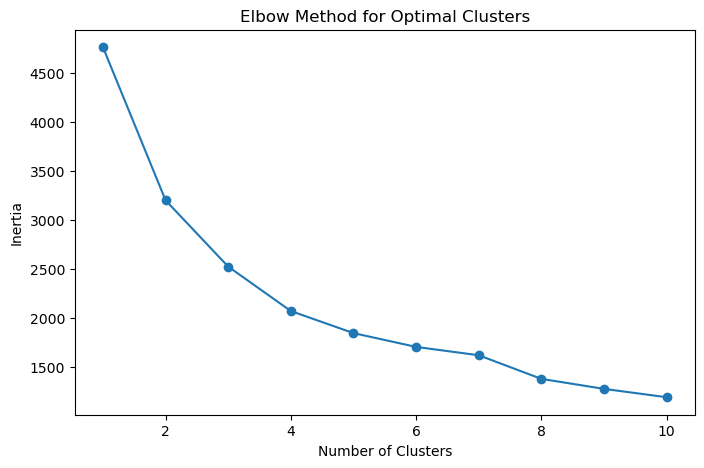

Best DBSCAN Parameters: {}, Silhouette Score: -1
Best GMM Components: 2, Silhouette Score: 0.31317553312251817


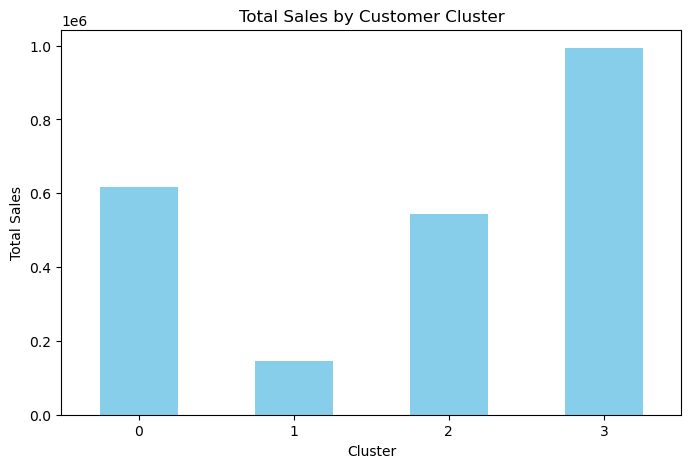

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98        78
           1       0.89      0.89      0.89        19
           2       0.88      1.00      0.93        14
           3       0.98      0.96      0.97        48

    accuracy                           0.96       159
   macro avg       0.93      0.96      0.94       159
weighted avg       0.96      0.96      0.96       159

Accuracy: 0.9622641509433962


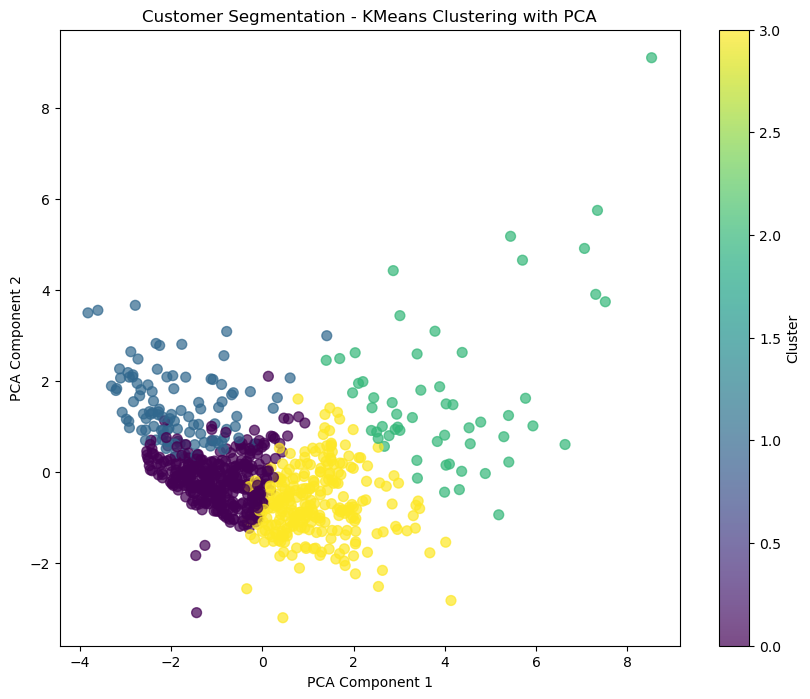

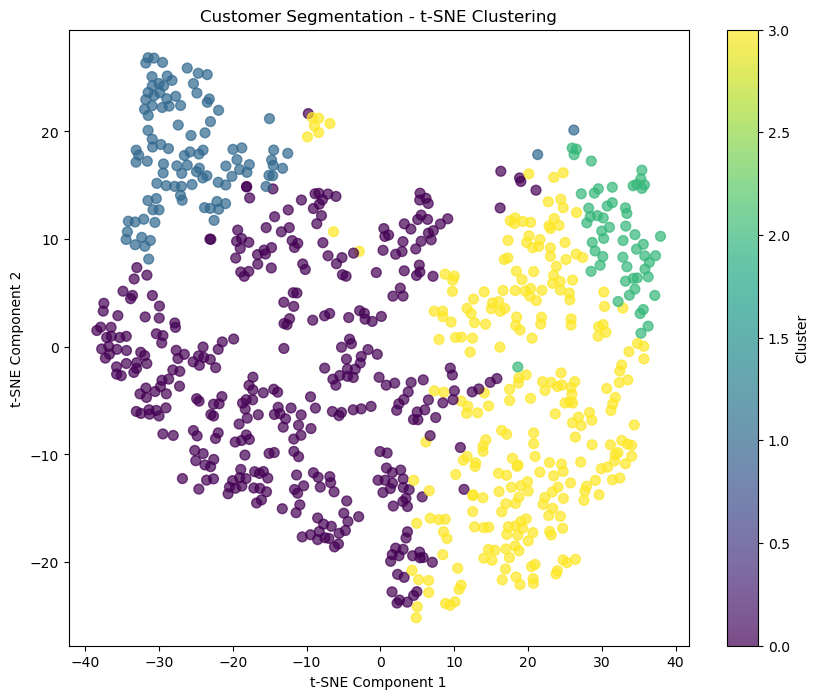

Silhouette Score for KMeans Clustering: 0.30256713387231576


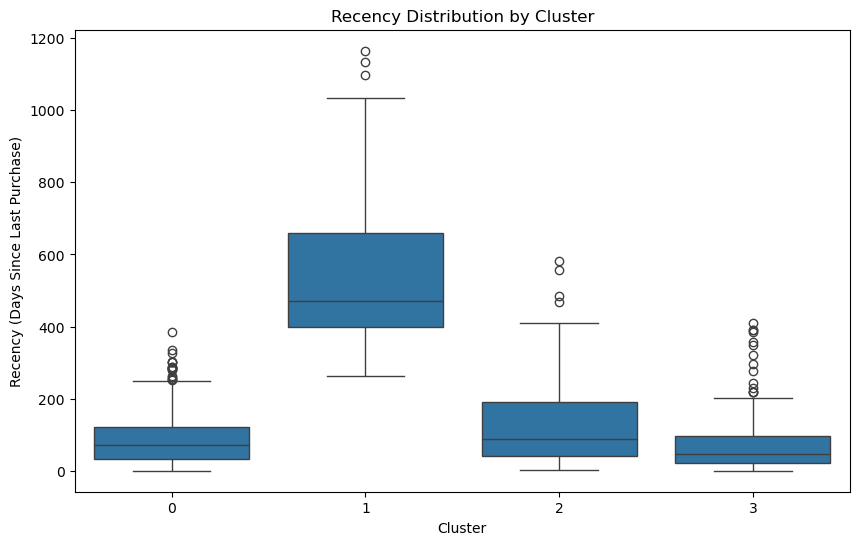

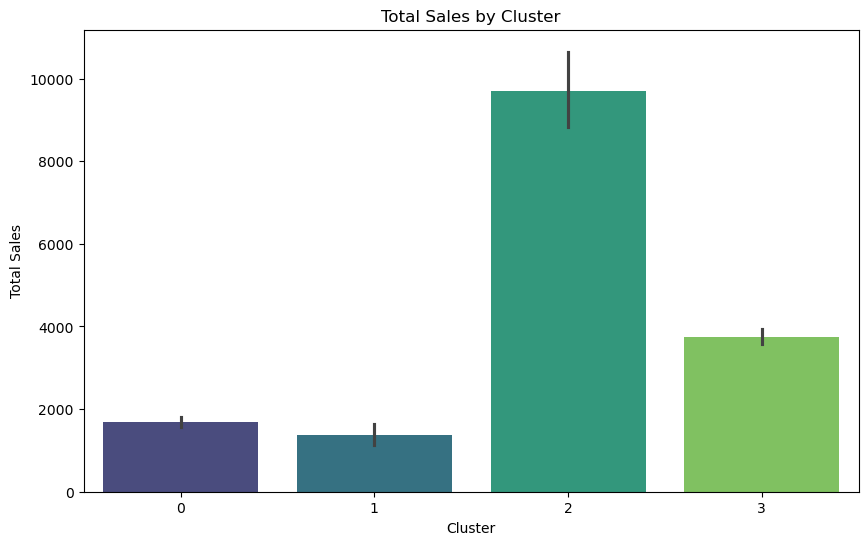

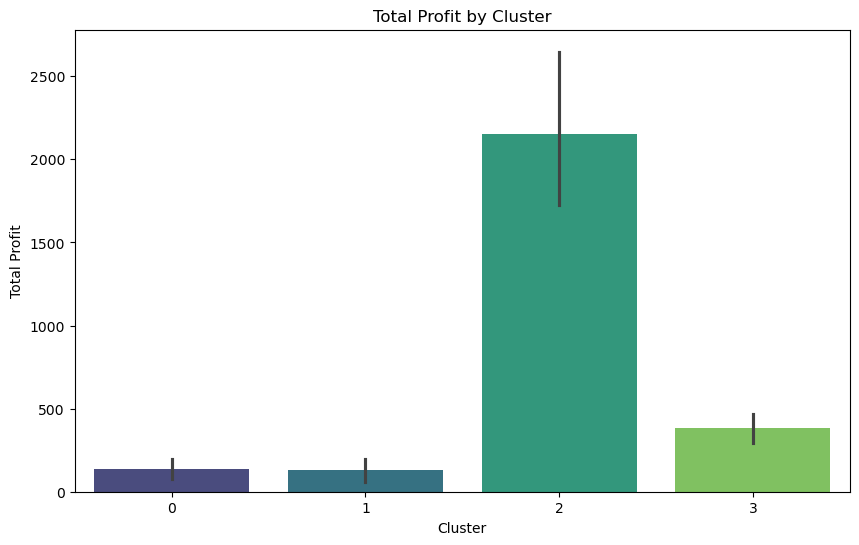

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Step 1: Read data and preprocess
# --------------------------------
df = pd.read_csv('Sample - Superstore.csv', encoding='ISO-8859-1')
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Calculate customer-specific features
customer_data = df.groupby('Customer ID').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Total_Quantity=('Quantity', 'sum'),
    First_Order_Date=('Order Date', 'min'),
    Last_Order_Date=('Order Date', 'max'),
    Num_Orders=('Order ID', 'nunique')
).reset_index()

customer_data['Recency'] = (customer_data['Last_Order_Date'].max() - customer_data['Last_Order_Date']).dt.days
customer_data['Frequency'] = customer_data['Num_Orders']
customer_data['Monetary'] = customer_data['Total_Sales']

# Select important features and standardize the data
features = customer_data[['Total_Sales', 'Total_Profit', 'Total_Quantity', 'Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 2: KMeans Clustering
# --------------------------------
# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Train KMeans with the optimal number of clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)
customer_data['Cluster_KMeans'] = kmeans_labels

# Step 3: DBSCAN Clustering
# --------------------------------
from sklearn.model_selection import ParameterGrid

param_grid = {'eps': [0.3, 0.5, 0.7], 'min_samples': [3, 5, 7]}
best_score = -1
best_params = {}

for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = dbscan.fit_predict(scaled_features)
    if len(set(labels)) > 1 and -1 not in set(labels):
        score = silhouette_score(scaled_features, labels)
        if score > best_score:
            best_score = score
            best_params = params

print(f"Best DBSCAN Parameters: {best_params}, Silhouette Score: {best_score}")

# Step 4: GMM Clustering
# --------------------------------
best_gmm_score = -1
best_gmm_components = 0

for n in range(2, 11):
    gmm = GaussianMixture(n_components=n, random_state=42)
    labels = gmm.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, labels)
    if score > best_gmm_score:
        best_gmm_score = score
        best_gmm_components = n

print(f"Best GMM Components: {best_gmm_components}, Silhouette Score: {best_gmm_score}")

# Step 5: Analyze clustering results
# --------------------------------
# Total sales by cluster
sales_by_cluster = customer_data.groupby('Cluster_KMeans')['Total_Sales'].sum()
plt.figure(figsize=(8, 5))
sales_by_cluster.plot(kind='bar', color='skyblue')
plt.title('Total Sales by Customer Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)
plt.show()

# Step 6: Train a predictive model for clusters
# --------------------------------
X = scaled_features
y = customer_data['Cluster_KMeans']

# Split train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Step 7: Evaluate and visualize results
# --------------------------------
# Dimensionality reduction with PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)
plt.figure(figsize=(10, 8))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=customer_data['Cluster_KMeans'], cmap='viridis', s=50, alpha=0.7)
plt.title('Customer Segmentation - KMeans Clustering with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(scaled_features)
plt.figure(figsize=(10, 8))
plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=customer_data['Cluster_KMeans'], cmap='viridis', s=50, alpha=0.7)
plt.title('Customer Segmentation - t-SNE Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Evaluate using Silhouette Score
silhouette_avg = silhouette_score(scaled_features, customer_data['Cluster_KMeans'])
print(f"Silhouette Score for KMeans Clustering: {silhouette_avg}")

# Analyze customer behavior by cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster_KMeans', y='Recency', data=customer_data)
plt.title('Recency Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Recency (Days Since Last Purchase)')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster_KMeans', y='Total_Sales', data=customer_data, palette='viridis')
plt.title('Total Sales by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Sales')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster_KMeans', y='Total_Profit', data=customer_data, palette='viridis')
plt.title('Total Profit by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Profit')
plt.show()

# 3. Customer Retention

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE  # Import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # Use Pipeline from imbalanced-learn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
# Read data
df = pd.read_csv('Sample - Superstore.csv', encoding='ISO-8859-1')

# Create features: Total number of purchases, total revenue, total profit
customer_summary = df.groupby('Customer ID').agg(
    frequency=('Order ID', 'nunique'),  # Number of purchases
    total_sales=('Sales', 'sum'),       # Total revenue
    total_profit=('Profit', 'sum'),     # Total profit
    segment=('Segment', 'first'),       # Customer's segment
    region=('Region', 'first')          # Customer's region
).reset_index()

# Convert Order Date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Get the current date
today = datetime.today()

# Calculate the last purchase date for each customer
last_purchase = df.groupby('Customer ID')['Order Date'].max().reset_index()
# Get the latest date in the 'Order Date' column
latest_date = df['Order Date'].max()
# Create a 'Churn' column: If the customer's last purchase date is more than 6 months ago, mark as churned
last_purchase['Churn'] = (latest_date - last_purchase['Order Date']).dt.days > 180  # 180 days = 6 months
last_purchase['Churn'] = last_purchase['Churn'].astype(int)

# Merge with customer_summary
customer_summary = pd.merge(customer_summary, last_purchase[['Customer ID', 'Churn']], on='Customer ID')

# One-Hot Encoding for categorical columns
customer_summary = pd.get_dummies(customer_summary, columns=['segment', 'region'], drop_first=True)

# Assume X and y are features and labels
X = customer_summary.drop(['Churn', 'Customer ID'], axis=1)  # Drop unnecessary columns
y = customer_summary['Churn']

# Split data into train/test sets with Stratified Sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Use SMOTE to balance the data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Build the pipeline
n_components = min(X_train.shape[1], 8)  # Ensure n_components <= number of features
pipeline = ImbPipeline([  # Use ImbPipeline from imbalanced-learn
    ('scaler', StandardScaler()),  # Standardize data
    ('pca', PCA(n_components=n_components)),  # Reduce dimensionality if needed
    ('classifier', RandomForestClassifier(random_state=42))  # RandomForestClassifier
])

# Tune hyperparameters with RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True, False]
}

# RandomizedSearchCV with Cross-Validation
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=50, cv=3, 
                                   n_jobs=-1, verbose=1, scoring='accuracy', random_state=42)

# Train the model with balanced data
random_search.fit(X_train_res, y_train_res)

# Results
print(f"Best Hyperparameters: {random_search.best_params_}")
print(f"Accuracy on Test Set: {random_search.score(X_test, y_test)}")

# Print classification results
y_pred = random_search.predict(X_test)
print(classification_report(y_test, y_pred))

# Evaluate with Cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cross_val_score(random_search.best_estimator_, X, y, cv=stratified_kfold)

# Calculate AUC score
y_prob = random_search.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {auc_score}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 20, 'classifier__bootstrap': False}
Accuracy on Test Set: 0.6764705882352942
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       178
           1       0.37      0.38      0.37        60

    accuracy                           0.68       238
   macro avg       0.58      0.58      0.58       238
weighted avg       0.68      0.68      0.68       238

AUC Score: 0.6210674157303371


# 4. Price Optimization

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import loguniform

# Read the data
df = pd.read_csv("Sample - Superstore.csv", encoding="ISO-8859-1")

# Calculate the average unit price
df['Unit Price'] = df['Sales'] / df['Quantity']

# Input columns and target variable
features = ['Unit Price', 'Discount', 'Quantity', 'Category', 'Sub-Category', 'Region']
target_sales = df['Sales']

# Log transformation for Profit
df['Profit'] = df['Profit'].apply(lambda x: np.log(x + 1) if x > 0 else 0)  # Apply log transformation

# Target variable for Profit after transformation
target_profit = df['Profit']

# Split the data into train/test sets (increased train ratio)
X_train, X_test, y_train_sales, y_test_sales = train_test_split(df[features], target_sales, test_size=0.2, random_state=42)
X_train, X_test, y_train_profit, y_test_profit = train_test_split(df[features], target_profit, test_size=0.2, random_state=42)

# Data preprocessing: Encode categorical variables and scale numeric variables
numeric_features = ['Unit Price', 'Discount', 'Quantity']
categorical_features = ['Category', 'Sub-Category', 'Region']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Random Forest Regressor with parameter optimization
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, warm_start=True))  # warm_start to reuse the model
])

# Parameter tuning using RandomizedSearchCV for time efficiency
param_dist = {
    'regressor__n_estimators': [100, 150, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 5],
    'regressor__max_features': ['auto', 'sqrt', 'log2'],
    'regressor__bootstrap': [True, False]
}

# Use RandomizedSearchCV instead of GridSearchCV to optimize runtime
random_search = RandomizedSearchCV(rf_pipeline, param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)

# Find the best parameters for the Sales model
random_search.fit(X_train, y_train_sales)

# Print the results of RandomizedSearchCV
print("Best parameters for Sales model:", random_search.best_params_)
print("Best score for Sales model:", random_search.best_score_)

# Predict and evaluate the Sales model
y_pred_sales = random_search.best_estimator_.predict(X_test)
print("MSE for Sales model:", mean_squared_error(y_test_sales, y_pred_sales))
print("R2 for Sales model:", r2_score(y_test_sales, y_pred_sales))

# Feature importance from the Random Forest model (Sales)
regressor_sales = random_search.best_estimator_.named_steps['regressor']
feature_importance_sales = pd.Series(regressor_sales.feature_importances_,
                                     index=random_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()).sort_values(ascending=False)

print("\nFeature Importance (Sales):\n", feature_importance_sales)

# Perform parameter tuning for the Profit model
random_search_profit = RandomizedSearchCV(rf_pipeline, param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search_profit.fit(X_train, y_train_profit)

# Print the results of RandomizedSearchCV for Profit
print("Best parameters for Profit model:", random_search_profit.best_params_)
print("Best score for Profit model:", random_search_profit.best_score_)

# Predict and evaluate the Profit model
y_pred_profit = random_search_profit.best_estimator_.predict(X_test)
print("MSE for Profit model:", mean_squared_error(y_test_profit, y_pred_profit))
print("R2 for Profit model:", r2_score(y_test_profit, y_pred_profit))

# Feature importance from the Random Forest model (Profit)
regressor_profit = random_search_profit.best_estimator_.named_steps['regressor']
feature_importance_profit = pd.Series(regressor_profit.feature_importances_,
                                     index=random_search_profit.best_estimator_.named_steps['preprocessor'].get_feature_names_out()).sort_values(ascending=False)

print("\nFeature Importance (Profit):\n", feature_importance_profit)

Best parameters for Sales model: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 'log2', 'regressor__max_depth': 30, 'regressor__bootstrap': False}
Best score for Sales model: -53769.16547371872
MSE for Sales model: 183493.7116112956
R2 for Sales model: 0.6893618221165666

Feature Importance (Sales):
 num__Unit Price                  0.669235
num__Quantity                    0.110055
cat__Sub-Category_Copiers        0.074480
cat__Category_Office Supplies    0.026193
cat__Sub-Category_Machines       0.024775
num__Discount                    0.021164
cat__Category_Technology         0.010693
cat__Sub-Category_Chairs         0.009348
cat__Sub-Category_Tables         0.009179
cat__Sub-Category_Furnishings    0.007479
cat__Region_East                 0.005901
cat__Region_South                0.005420
cat__Sub-Category_Storage        0.004187
cat__Region_West                 0.003454
cat__Sub-Category_Paper     

# 5. Shipping Time Prediction

[I 2024-12-07 10:30:33,409] A new study created in memory with name: no-name-ff5ab739-cb72-4705-8cb2-23d9289667a9
[I 2024-12-07 10:30:41,402] Trial 0 finished with value: 0.865122405342059 and parameters: {'n_estimators': 53, 'max_depth': 15, 'learning_rate': 0.03095566322883625, 'num_leaves': 36}. Best is trial 0 with value: 0.865122405342059.
[I 2024-12-07 10:30:48,837] Trial 1 finished with value: 0.93841959845808 and parameters: {'n_estimators': 60, 'max_depth': 10, 'learning_rate': 0.016440619449976254, 'num_leaves': 42}. Best is trial 0 with value: 0.865122405342059.
[I 2024-12-07 10:30:59,804] Trial 2 finished with value: 0.8222435745992255 and parameters: {'n_estimators': 193, 'max_depth': 19, 'learning_rate': 0.017476566837925096, 'num_leaves': 44}. Best is trial 2 with value: 0.8222435745992255.
[I 2024-12-07 10:31:09,644] Trial 3 finished with value: 0.8591707742442695 and parameters: {'n_estimators': 188, 'max_depth': 7, 'learning_rate': 0.1469173571346919, 'num_leaves': 45

Best parameters: {'n_estimators': 55, 'max_depth': 8, 'learning_rate': 0.11219197349922742, 'num_leaves': 21}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 7995, number of used features: 32
[LightGBM] [Info] Start training from score 3.965353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
MAE: 0.8205553548091707
MSE: 1.0005803889595464
R²: 0.673339476461596
Train MAE: 0.7756447822563218, Test MAE: 0.8205553548091707
Model saved as 'optimized_lgbm_model.pkl'


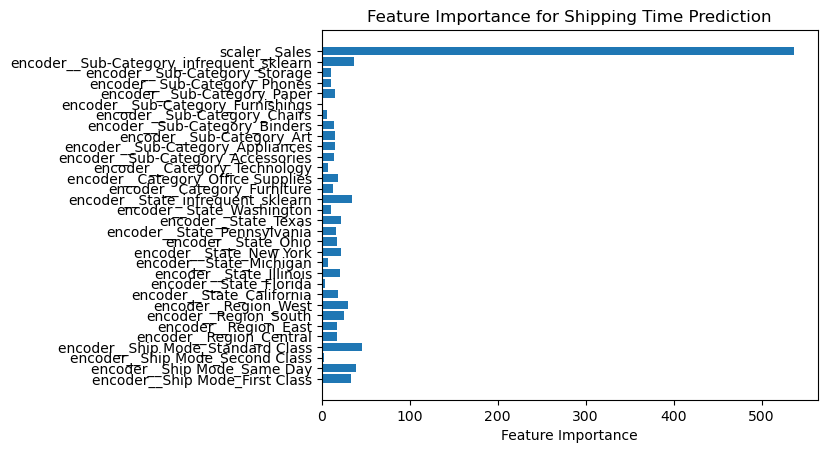

In [11]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
import optuna
import joblib
import matplotlib.pyplot as plt

# Read data
df = pd.read_csv("Sample - Superstore.csv", encoding="ISO-8859-1")

# Clean data
df = df.dropna()

# Create the 'Shipping Time (Days)' column
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
df['Shipping Time (Days)'] = (df['Ship Date'] - df['Order Date']).dt.days
df = df[df['Shipping Time (Days)'] >= 0]

# Select necessary columns
data = df[['Ship Mode', 'Region', 'State', 'Sales', 'Category', 'Sub-Category', 'Shipping Time (Days)']]
data['Sales'] = np.log1p(data['Sales'])  # Transform Sales to reduce the impact of outliers

# Define features and target
X = data.drop('Shipping Time (Days)', axis=1)
y = data['Shipping Time (Days)']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Process categorical columns and standardize numerical columns
categorical_features = ['Ship Mode', 'Region', 'State', 'Category', 'Sub-Category']
numerical_features = ['Sales']
ct = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(max_categories=10, handle_unknown='infrequent_if_exist'), categorical_features),
        ('scaler', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

# Optuna for model parameter optimization
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)  # Limit the number of n_estimators
    max_depth = trial.suggest_int('max_depth', 5, 20)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    num_leaves = trial.suggest_int('num_leaves', 20, 50)
    
    model = LGBMRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        random_state=42
    )
    
    pipeline = Pipeline(steps=[
        ('preprocessor', ct),
        ('regressor', model)
    ])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    return -scores.mean()  # Return the negative value of MAE for Optuna to minimize

# Run Optuna to find the best parameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  # Reduce the number of trials to save time
print(f"Best parameters: {study.best_params}")

# Apply the best parameters to create the final model
best_params = study.best_params
final_model = LGBMRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    num_leaves=best_params['num_leaves'],
    random_state=42
)

# Create the final pipeline with the optimized model
final_pipeline = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', final_model)
])

# Train the model on the training set
final_pipeline.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = final_pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")

# Check for overfitting
train_pred = final_pipeline.predict(X_train)
train_mae = mean_absolute_error(y_train, train_pred)
print(f"Train MAE: {train_mae}, Test MAE: {mae}")

# Save the model
# joblib.dump(final_pipeline, 'optimized_lgbm_model.pkl')
print("Model saved as 'optimized_lgbm_model.pkl'")

# (Optional) Display a feature importance plot
feature_importances = final_model.feature_importances_
feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Shipping Time Prediction')
plt.show()


# 6. Fraud Detection

In [13]:
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.pipeline import Pipeline

# Read data
df = pd.read_csv('Sample - Superstore.csv', encoding='ISO-8859-1')

# Convert date columns to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Create an additional column "Net Sales" to calculate revenue after discount
df['Net Sales'] = df['Sales'] * (1 - df['Discount'])

# Handle missing or anomalous data (if any)
imputer = SimpleImputer(strategy='mean')
df['Sales'] = imputer.fit_transform(df[['Sales']])

# Select relevant features
features = ['Discount', 'Quantity', 'Sales', 'Postal Code', 'Region']

# One-Hot Encoding for categorical columns
df = pd.get_dummies(df, columns=['Region', 'Segment'], drop_first=True)

# Create new features
df['High Discount'] = df['Discount'] > 0.5  # Flag orders with high discounts
df['High Sales'] = df['Sales'] > 500  # Flag orders with high sales

# Select features for model training
X = df[['Discount', 'Quantity', 'Sales', 'Postal Code', 'High Discount', 'High Sales'] + [col for col in df.columns if 'Region' in col]]

# Ensure invalid values are removed
X = X[X['Sales'] > 0]  # Remove rows with Sales <= 0

# Create target labels for anomaly detection
y = np.where(df['Sales'] > 1000, 1, 0)  # 1 for "Anomalous", 0 for "Normal"

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to rebalance classes
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Create a Pipeline with PCA (dimensionality reduction) and RandomForestClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize data
    ('pca', PCA(n_components=5)),  # Dimensionality reduction
    ('model', RandomForestClassifier(random_state=42, class_weight='balanced'))  # RandomForest model with class balancing
])

# Set up parameters for tuning with RandomizedSearchCV
param_dist = {
    'model__n_estimators': [100, 200, 300],  # Increase the number of trees
    'model__max_depth': [None, 10, 20],  # Increase tree depth
    'model__min_samples_split': [2, 5, 10],  # Adjust minimum samples for splitting
    'model__class_weight': ['balanced', None]  # Balance class weights
}

# Use RandomizedSearchCV instead of GridSearchCV for more efficient parameter search
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=20, cv=3, scoring='accuracy', n_jobs=-1, verbose=1, random_state=42)

# Train the model with RandomizedSearchCV
random_search.fit(X_train_res, y_train_res)

# Print the best parameters
print(f"Optimal parameters: {random_search.best_params_}")

# Predict with the optimal model
y_pred = random_search.predict(X_test)

# Generate classification report
print(classification_report(['Fraud' if x == 1 else 'Not Fraud' for x in y_test],
                            ['Fraud' if x == 1 else 'Not Fraud' for x in y_pred]))

# Confusion matrix
print(confusion_matrix(['Fraud' if x == 1 else 'Not Fraud' for x in y_test],
                       ['Fraud' if x == 1 else 'Not Fraud' for x in y_pred]))

# ROC-AUC
y_prob = random_search.predict_proba(X_test)[:, 1]  # Predict probabilities for class 1
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC AUC: {roc_auc}')

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
print(f'Precision-Recall AUC: {pr_auc}')

# Cross-validation with StratifiedKFold to maintain class ratio
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(random_search.best_estimator_, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"Cross-validation scores: {cross_val_scores}")
print(f"Average accuracy from Cross-validation: {cross_val_scores.mean()}")

# Save the trained model
#joblib.dump(random_search.best_estimator_, 'best_model.pkl')

# Load the saved model
#model = joblib.load('best_model.pkl')


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__max_depth': 20, 'model__class_weight': 'balanced'}
              precision    recall  f1-score   support

       Fraud       0.84      0.98      0.91       158
   Not Fraud       1.00      0.99      0.99      2841

    accuracy                           0.99      2999
   macro avg       0.92      0.99      0.95      2999
weighted avg       0.99      0.99      0.99      2999

[[ 155    3]
 [  29 2812]]
ROC AUC: 0.9990008420996351
Precision-Recall AUC: 0.9854766909461709
Cross-validation scores: [0.9949975  0.993997   0.99449725 0.9909955  0.9954955 ]
Average accuracy from Cross-validation: 0.9939965478234614
